# Установка модулей

## Импорт модулей, не связанных с PySpark

In [39]:
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Импорт модулей, связанных с PySpark

In [40]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


## Инициализация датасета

In [41]:
MAX_MEMORY = '4G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/lab1test.csv'
# Load the main data set into pyspark data frame 
# df = spark.read.json(filename_data, mode="DROPMALFORMED")
df = spark.read.option("inferSchema",True) \
                 .option("delimiter",",") \
                 .option("header", True) \
                .csv(filename_data)

# Вывод типа датасета
print('Тип датафрейма: ' + str(type(df)))

# Вывод содержимого датасета
print('Содержимое датафрейма:')
df.show(truncate=15)

Тип датафрейма: <class 'pyspark.sql.dataframe.DataFrame'>
Содержимое датафрейма:
+---------+---------------+---------------+---------------+---------------+------------+---------------+---------------+---------------+
|    LCLid|            day|  energy_median|    energy_mean|     energy_max|energy_count|     energy_std|     energy_sum|     energy_min|
+---------+---------------+---------------+---------------+---------------+------------+---------------+---------------+---------------+
|MAC000131|2011-12-15 0...|          0.485|0.4320454545...|          0.868|          22|0.2391457967...|          9.505|0.0720000000...|
|MAC000131|2011-12-16 0...|         0.1415|0.2961666687...|      1.1160001|          48|0.2814713178...|14.216000100...|          0.031|
|MAC000131|2011-12-17 0...|         0.1015|      0.1898125|          0.685|          48|0.1884046862...|          9.111|          0.064|
|MAC000131|2011-12-18 0...|          0.114|0.2189791666...|0.6759999999...|          48|0.2029192

In [42]:
# Вывод типов столбцов
print('Обзор данных')
df.printSchema()

Обзор данных
root
 |-- LCLid: string (nullable = true)
 |-- day: timestamp (nullable = true)
 |-- energy_median: double (nullable = true)
 |-- energy_mean: double (nullable = true)
 |-- energy_max: double (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- energy_std: double (nullable = true)
 |-- energy_sum: double (nullable = true)
 |-- energy_min: double (nullable = true)



In [43]:
# Удаляем столбцы LCLid и day
df = df.drop("LCLid", "day")
df.show(truncate=20)

+-------------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|      energy_median|        energy_mean|        energy_max|energy_count|         energy_std|        energy_sum|         energy_min|
+-------------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|              0.485|0.43204545454545457|             0.868|          22|0.23914579678767536|             9.505|0.07200000000000001|
|             0.1415|0.29616666875000003|         1.1160001|          48| 0.2814713178628203|14.216000100000002|              0.031|
|             0.1015|          0.1898125|             0.685|          48| 0.1884046862418033|             9.111|              0.064|
|              0.114| 0.2189791666666666|0.6759999999999999|          48|0.20291927853038208|10.510999999999996|              0.065|
|              0.191|0.32597916666666665|0.7879999999999999|         

## Нахождение пропущенных значений

In [44]:
# Фукция поиска пропущенных значений в датафрейме
def findMissValue():
    df.select(*[
        (
            F.count(F.when((F.isnan(c)) | (F.col(c).isNull()) | (F.col(c)=='None') | (F.col(c)=='NULL') | (F.col(c)==''), c)) if t not in ("timestamp", "date")
            else F.count(F.when((F.col(c).isNull()) | (F.col(c)=='None') | (F.col(c)=='NULL') | (F.col(c)==''), c))
        ).alias(c)
        for c, t in df.dtypes if c in df.columns
    ]).show()

In [45]:
# вызов функции поиска пропущенных значений и отображения их количества
print("Кол-во пропущенных значений в датафрейме")
findMissValue()

# Удаление всех пропущенных значений
df = df.na.drop("any")

# вызов функции поиска пропущенных значений и отображения их количества
print("Кол-во пропущенных значений в датафрейме, после удаления")
findMissValue()

Кол-во пропущенных значений в датафрейме
+-------------+-----------+----------+------------+----------+----------+----------+
|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|
+-------------+-----------+----------+------------+----------+----------+----------+
|           30|         30|        30|           0|     11331|        30|        30|
+-------------+-----------+----------+------------+----------+----------+----------+

Кол-во пропущенных значений в датафрейме, после удаления
+-------------+-----------+----------+------------+----------+----------+----------+
|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|
+-------------+-----------+----------+------------+----------+----------+----------+
|            0|          0|         0|           0|         0|         0|         0|
+-------------+-----------+----------+------------+----------+----------+----------+



## Поиск выбросов

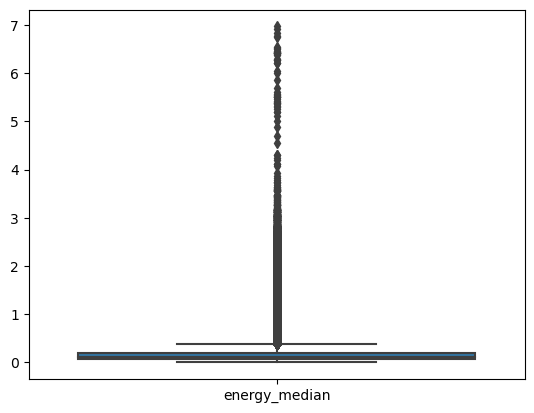

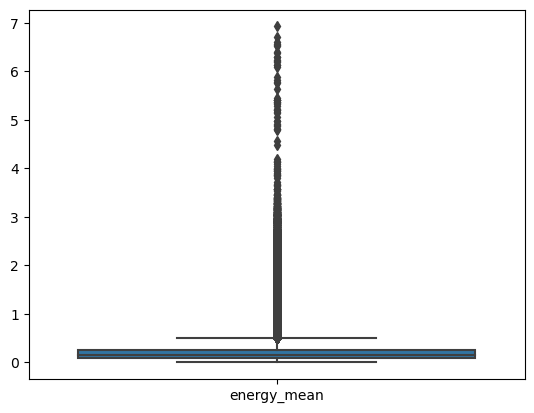

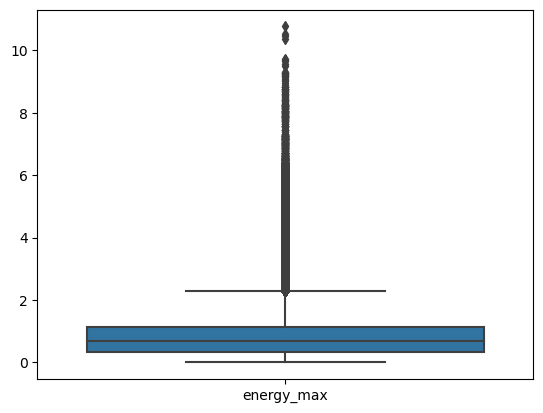

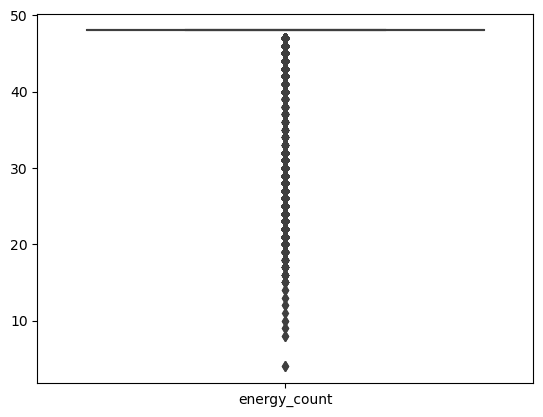

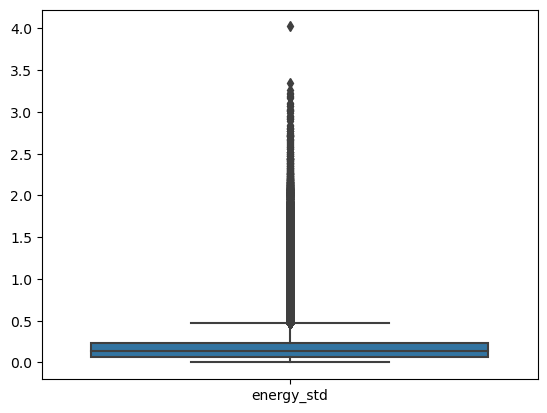

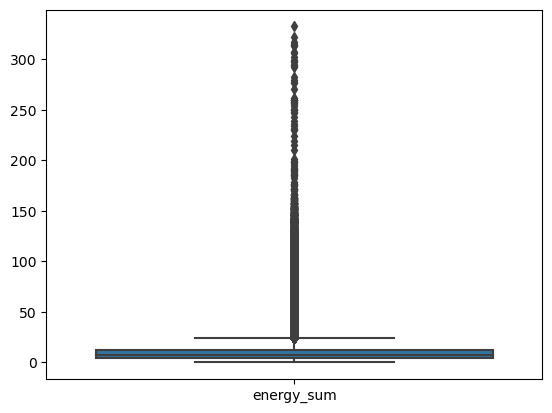

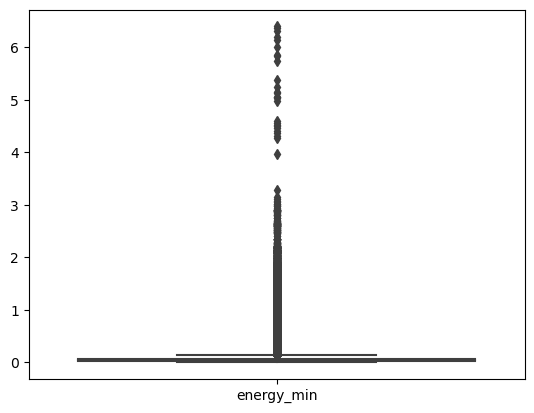

In [46]:
# Функция отображения графиков для наблюдения выбросов
def digrams_of_outliers(df):
    for c in df.columns: 
        column_df = df.select(c).toPandas()
        sns.boxplot(column_df)
        plt.show()
digrams_of_outliers(df)

In [47]:
# Функция получения границ
def get_bounds(df):
    # поиск перцентилей с 0 ошибкой
    bounds = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in df.columns
    }

    # поиск границ
    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
    return bounds

# Функция отображения количества выбросов по столбцам
def number_of_outliers(df, bounds):
    
    outliers_table_df = df.select(
    [
        F.when(
            F.col(c).between(bounds[c]['lower'], bounds[c]['upper']), 0
        ).otherwise(1).alias(c+"_out") 
        for c in df.columns
    ])

    outliers_df = outliers_table_df.select([
                        (
                            F.count(F.when((F.col(c)=='1'), c))
                        ).alias(c)
                        for c in outliers_table_df.columns])
    # отображение кол-ва выбросов по столбцам
    outliers_df.show()
bounds = get_bounds(df)

print("Кол-во выбросов по столбцам:")
number_of_outliers(df, bounds)
# Замена выбросов на пропущенные значения
df = df.select(
     *[
        F.when(
             F.col(c).between(bounds[c]['lower'], bounds[c]['upper']), F.col(c)
         ).otherwise(None).alias(c) 
        for c in df.columns
     ]
 )
# Удаление выбросов
df = df.dropna()
print("Кол-во выбросов по столбцам, после удаления выбросов:")
number_of_outliers(df, bounds)

Кол-во выбросов по столбцам:
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|energy_median_out|energy_mean_out|energy_max_out|energy_count_out|energy_std_out|energy_sum_out|energy_min_out|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|           224973|         201317|        121012|           29750|        158187|        201339|        221460|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+

Кол-во выбросов по столбцам, после удаления выбросов:
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|energy_median_out|energy_mean_out|energy_max_out|energy_count_out|energy_std_out|energy_sum_out|energy_min_out|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|           

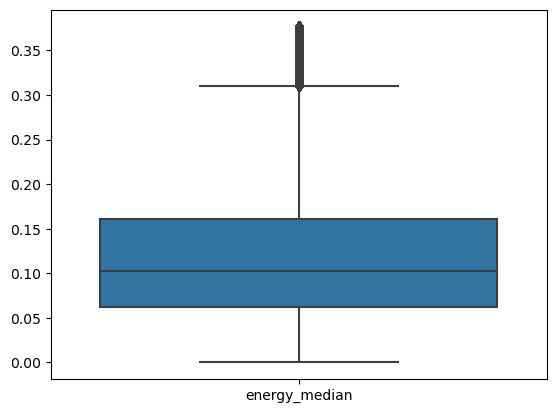

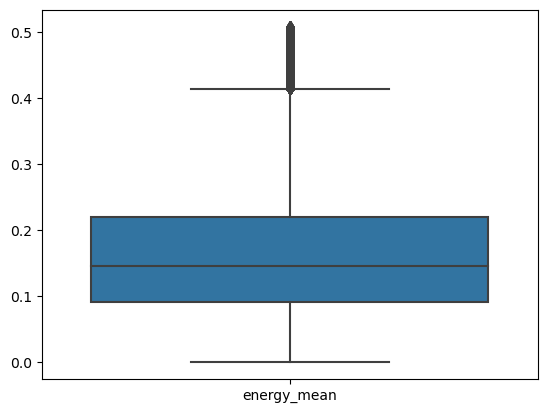

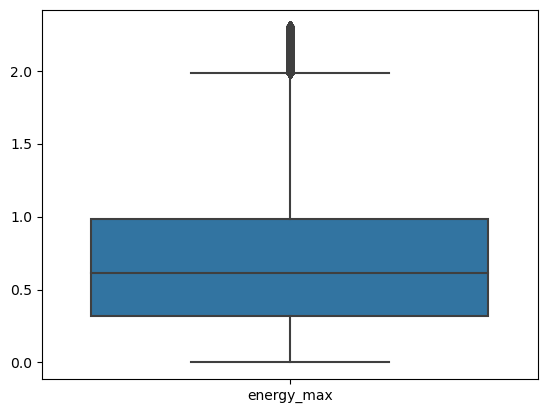

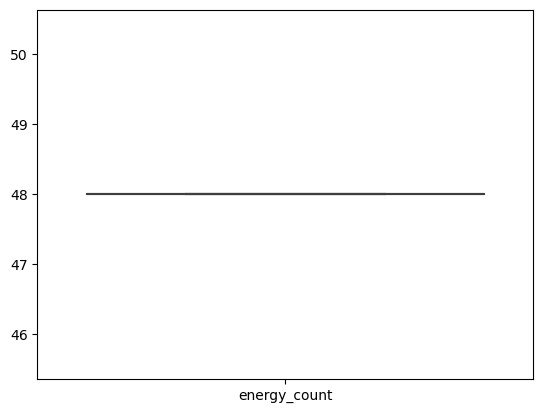

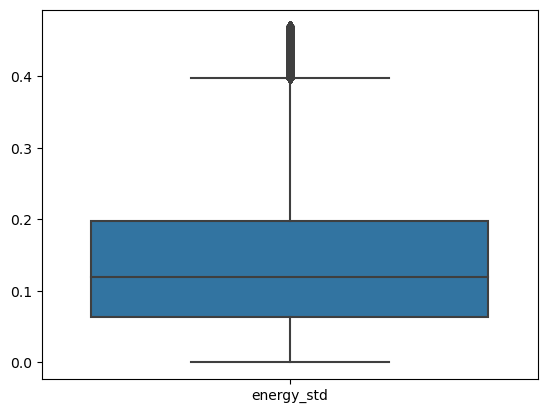

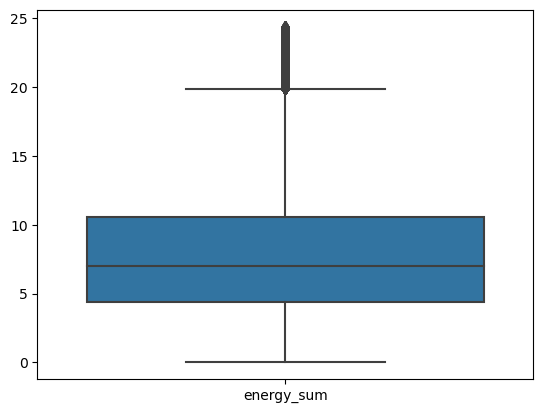

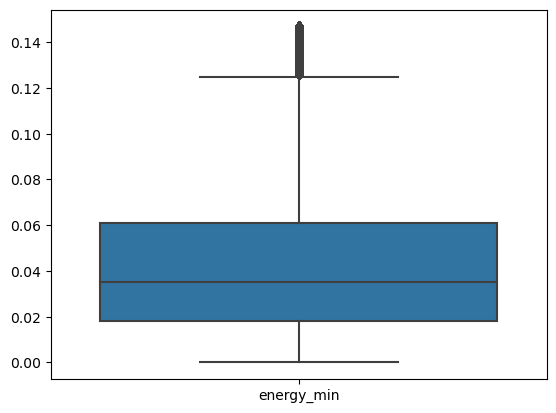

In [48]:
# Отображение графиков после удаления выбросов
digrams_of_outliers(df)

## Отображение статистических данных

In [59]:
removed_df = df.toPandas().describe().astype(float)
removed_df.T

,count,mean,std,min,25%,50%,75%,max
energy_median,3053252.0,0.118768,0.074528,0.0,0.062000,0.103000,0.161000,0.377000
energy_mean,3053252.0,0.163161,0.094318,0.0,0.090979,0.146500,0.220083,0.508542
energy_max,3053252.0,0.695165,0.465291,0.0,0.316000,0.612000,0.983000,2.303000
energy_std,3053252.0,0.140305,0.097866,0.0,0.063570,0.118744,0.197008,0.469602
energy_sum,3053252.0,7.831735,4.527253,0.0,4.367000,7.032000,10.564000,24.410000
energy_min,3053252.0,0.042886,0.032184,0.0,0.018000,0.035000,0.061000,0.147000


## Построение матрицы корреляции

In [49]:
# Перевести столбцы в векторный вид
assembler = VectorAssembler(
    inputCols=df.columns,
    outputCol="features")
print('До перевода:')
df.show()
print('После перевода:')
output = assembler.transform(df)
output.select("features").show(truncate=False)

# ПОСТРОЕНИЕ МАТРИЦЫ КОРРЕЛЯЦИИ МЕЖДУ ПРИЗНАКАМИ
# Построение самой матрицы
matrix = Correlation.corr(output, "features").collect()[0][0]

# Перевод матрицы в лист, для дальнейшего правильного отображения
corrmatrix = matrix.toArray().tolist()

# Копия колонок из исходного датасета, для формирования матрицы корреляции
columns = df.columns

# Формированиt матрицы корреляции
df_corr = spark.createDataFrame(corrmatrix, columns)

df_corr.show()

До перевода:
+-------------------+-------------------+------------------+------------+-------------------+------------------+----------+
|      energy_median|        energy_mean|        energy_max|energy_count|         energy_std|        energy_sum|energy_min|
+-------------------+-------------------+------------------+------------+-------------------+------------------+----------+
|             0.1415|0.29616666875000003|         1.1160001|          48| 0.2814713178628203|14.216000100000002|     0.031|
|             0.1015|          0.1898125|             0.685|          48| 0.1884046862418033|             9.111|     0.064|
|              0.114| 0.2189791666666666|0.6759999999999999|          48|0.20291927853038208|10.510999999999996|     0.065|
|              0.191|0.32597916666666665|0.7879999999999999|          48| 0.2592049619947409|15.646999999999998|     0.066|
|0.21800000000000005|             0.3575|             1.077|          48|0.28759657027517305|             17.16|     0.

In [55]:
df = df.drop("energy_count")

## Вывод графиков

array([[<AxesSubplot: title={'center': 'energy_median'}>,
        <AxesSubplot: title={'center': 'energy_mean'}>],
       [<AxesSubplot: title={'center': 'energy_max'}>,
        <AxesSubplot: title={'center': 'energy_std'}>],
       [<AxesSubplot: title={'center': 'energy_sum'}>,
        <AxesSubplot: title={'center': 'energy_min'}>]], dtype=object)

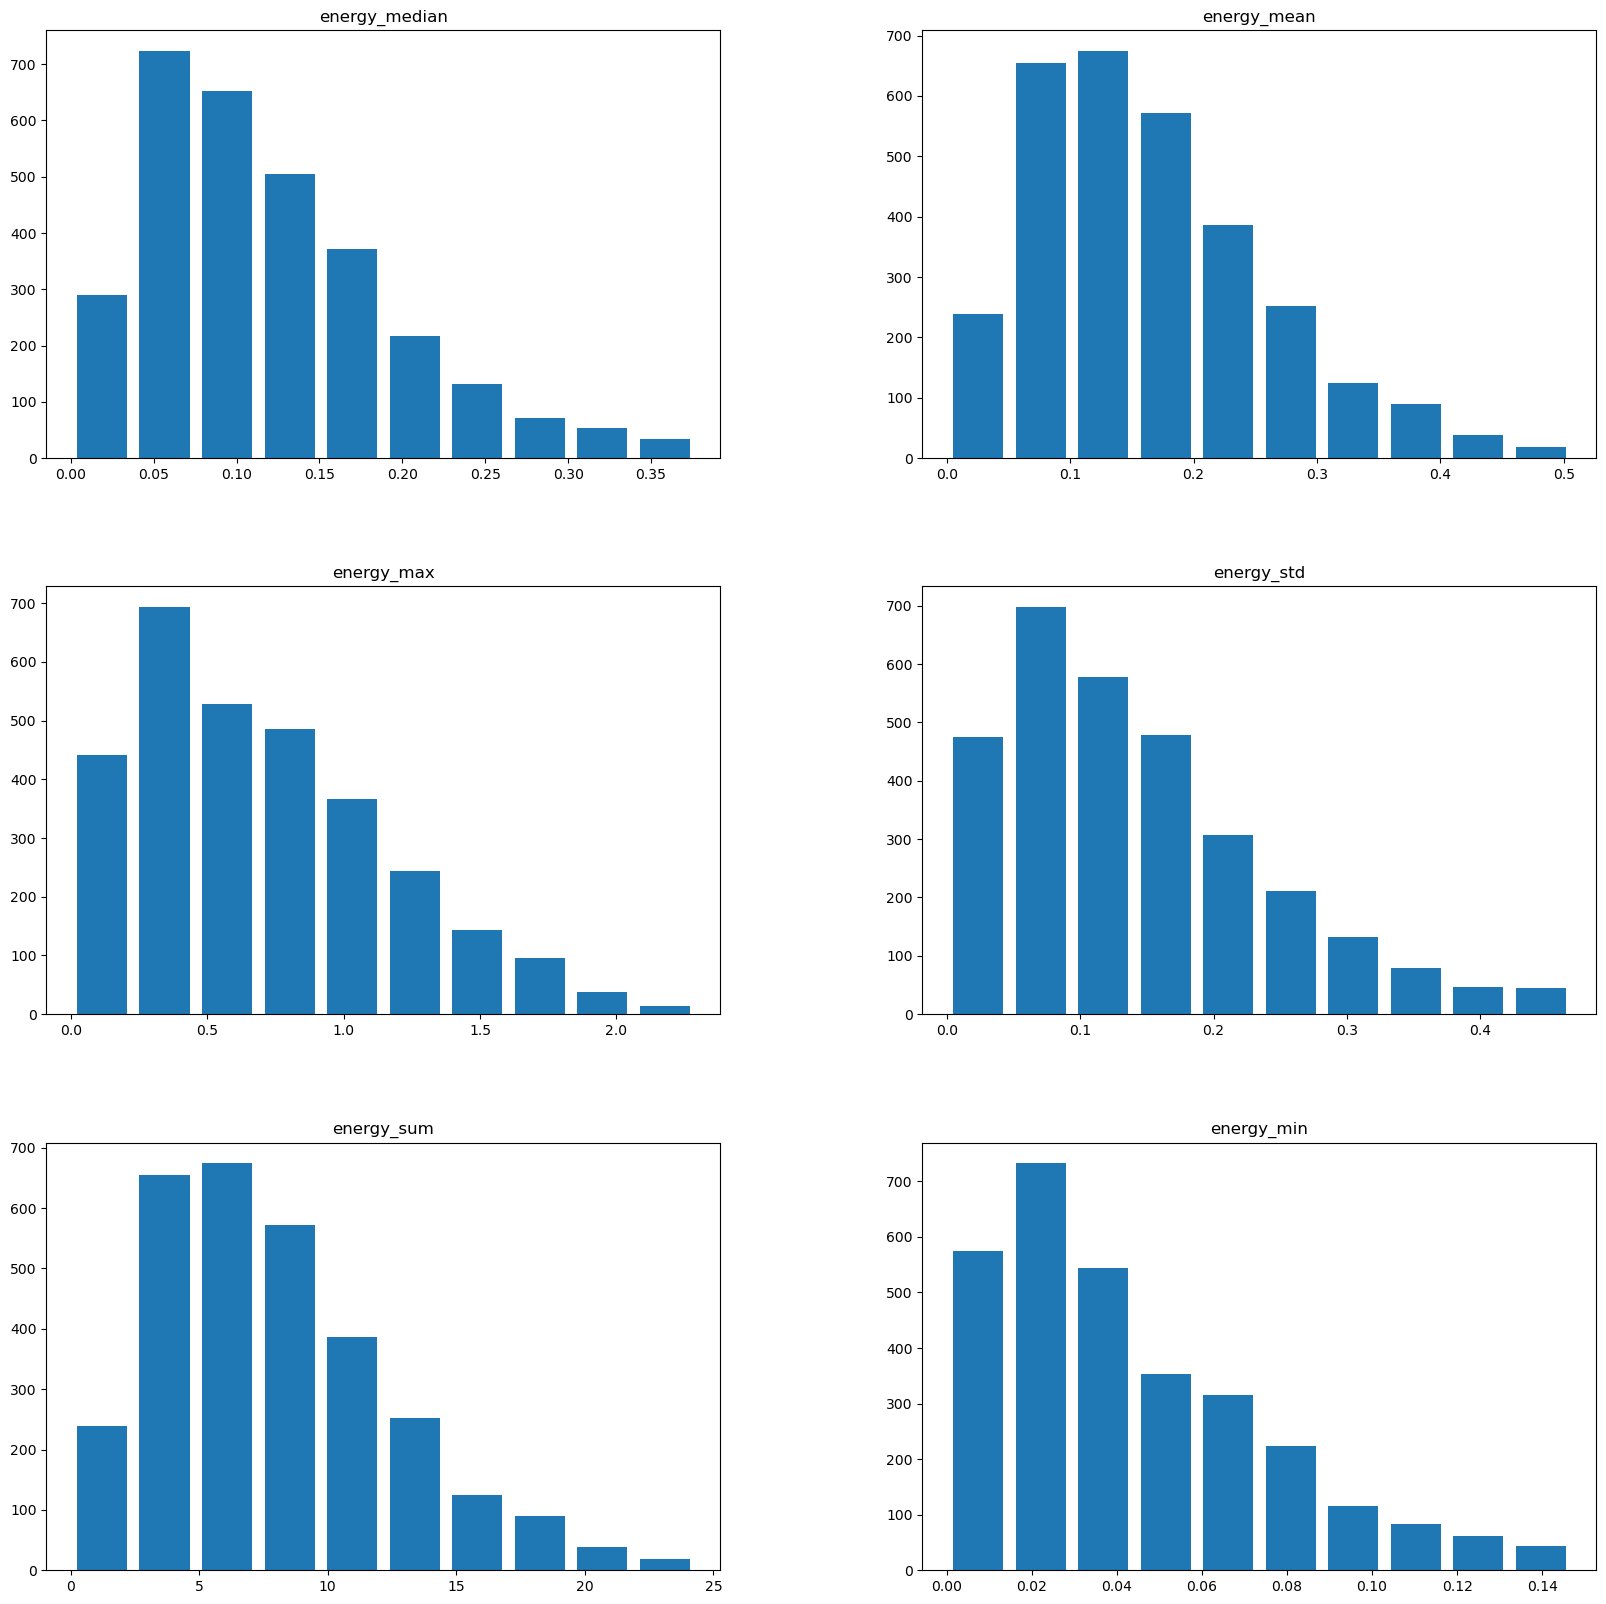

In [58]:
New_df = df.sample(True, 0.001, seed=42)
New_df = New_df.toPandas()
New_df.hist(figsize = (20,20), grid = False, rwidth = 0.8)